In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = [10, 7]
plt.matplotlib.rcParams.update({'font.size': 18})

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import requests
import datetime
import copy
import math
import pickle

from tqdm.auto import tqdm
from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

from jax import random
import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive
import jax.random as random
import jax.numpy as jnp

import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

import mechafil.data as mechafil_data
from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

from pycoingecko import CoinGeckoAPI
import datetime as dt

cg = CoinGeckoAPI()

from joblib import Parallel, delayed
import dill as pickle
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects

In [3]:
offline_folder = 'offline_info'
results_folder = 'results'
os.makedirs(offline_folder, exist_ok=True)
os.makedirs(results_folder, exist_ok=True)

In [4]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# set the simulation start date
#today = datetime.datetime.now().date() - timedelta(days=1)
today = datetime.date(2023, 5, 1)
DATA_LAG_DAYS = 0
current_date = today - timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - date(2020, 10, 15)).days

start_date = datetime.date(2022, 1, 1)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*8)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2022-01-01
2023-05-01
2031-04-29


In [5]:
mechafil_data.setup_spacescope('/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json')

In [6]:
fpp = os.path.join(offline_folder, 'historical_inputs.pkl')
if os.path.exists(fpp):
    with open(fpp, 'rb') as f:
        z = pickle.load(f)
    t_rr = z['t_rr']
    historical_rr = z['rr']
    t_fpr = z['t_fpr']
    historical_fpr = z['fpr']
    t_rbp = z['t_rbp']
    historical_rbp = z['rbp']
else:
    t_rr, historical_rr = u.get_historical_renewal_rate(start_date, current_date)
    t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)
    t_rbp, historical_rbp = u.get_historical_daily_onboarded_power(start_date, current_date)

    save_dict = {
        't_rr': t_rr,
        'rr': historical_rr,
        't_fpr': t_fpr,
        'fpr': historical_fpr,
        't_rbp': t_rbp,
        'rbp': historical_rbp
    }
    with open(fpp, 'wb') as f:
        pickle.dump(save_dict, f)

In [7]:
fp = os.path.join(offline_folder, 'historical_network_stats.pkl')
if os.path.exists(fp):
    with open(fp, 'rb') as f:
        z = pickle.load(f)
#     historical_renewal_rate =  z['historical_renewal_rate']
#     t_fpr = z['t_fpr']
#     historical_fpr = z['historical_fpr']
    fil_stats_df = z['fil_stats_df']
    sector_expiration_stats_offline = z['sector_expiration_stats']
else:
    #_, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)
    #t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)
    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    sector_expiration_stats_offline = get_sector_expiration_stats(start_date, current_date,end_date)
    
    dict_out = {
#         'historical_renewal_rate': historical_renewal_rate,
#         't_fpr': t_fpr,
#         'historical_fpr': historical_fpr,
        'fil_stats_df': fil_stats_df,
        'sector_expiration_stats': sector_expiration_stats_offline
    }
    with open(fp, 'wb') as f:
        pickle.dump(dict_out, f)
        
# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

MEGA = 1_000_000

In [8]:
def get_ts(id_='filecoin'):
    change_t = lambda x : datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d')
    now = int(datetime.datetime.utcnow().timestamp())
    start_ago = int((datetime.datetime.utcnow() - dt.timedelta(700)).timestamp())
    ts = cg.get_coin_market_chart_range_by_id(id=id_,
                                              vs_currency='usd',
                                              from_timestamp=start_ago,to_timestamp=now
                                             )
    
    ts_df = pd.DataFrame({"coin" : id_,
                          "time_s" : np.array(ts['prices']).T[0],
                      "time_d" : list(map(change_t, np.array(ts['prices']).T[0])),
                      "price" : np.array(ts['prices']).T[1],
                      "market_caps" : np.array(ts['market_caps']).T[1], 
                      "total_volumes" : np.array(ts['total_volumes']).T[1]})
    
    return ts_df

# find baseline crossings
def find_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[df_i.network_RBP.values/EIB < baseline]
        if len(df_crossing) > 0:
            xing_i = df_i[df_i.network_RBP.values/EIB < baseline].index[0]
            xing = np.append(xing,xing_i)
    return xing

def baseline_storage(epoch:float)->float:
    # Spec value:
    # BASELINE_B0 = 2.88888888 
    # The following value is required to match sentinel
    # to Reproduce the first baseline crossing in backtest.
    # It's also close to the value the starboard use: 2.77. 
    # !Someone should look more closely at this.
    BASELINE_B0 = 2.7636 
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

def filter_df_date(df_in, min_date, max_date):
    df_out = df_in[(df_in['date']>= pd.to_datetime(min_date)) & (df_in['date']<=pd.to_datetime(max_date))]
    return df_out

def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
            df_out[c] = df_out[c].clip(lower=1e-6)
#             df_out[c] = df_out[c].clip(lower=0)
    return df_out

# add ROI to trajectory
def add_generated_quantities(cil_rbp, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
#     df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP'])
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / cil_rbp.network_QAP
    
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']

    cil_rbp['3y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365*3).sum().shift(-365*3+1).values.flatten()
    cil_rbp['3y_sector_roi'] = cil_rbp['3y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']
    cil_rbp['3y_roi_annualized'] = np.power(cil_rbp['3y_sector_roi'] + 1, 1./3) - 1
    return cil_rbp

def add_USD_generated_quantities(df:pd.DataFrame, 
                                 price_df,
                                 costs=0, 
                                 future_price=3,
                                 duration_yr=1,
                                 ramp_len=60)->pd.DataFrame:
    
    COSTS = costs # FIL per sector
    final_real_price = price_df.price.values[-1]
    len_fil = df.shape[0] - price_df.shape[0]
    len_remain = len_fil - ramp_len
    df['usd'] = np.concatenate([price_df.price.values, 
                                np.linspace(final_real_price, future_price, ramp_len),
                                np.repeat(future_price, len_remain)])

    df['day_pledge_per_TIB_USD'] = df['day_pledge_per_QAP'] * df['usd'] / SECTOR_SIZE * TIB
    df['day_pledge_per_QAP_USD'] = df['day_pledge_per_QAP'] * df['usd']
    df['day_rewards_per_sector_USD'] = df['day_rewards_per_sector'] * df['usd']
    
    df['1y_return_per_sector_USD'] = df['day_rewards_per_sector_USD'].rolling(365).sum().shift(-365+1).values.flatten()
    df['1y_sector_roi_USD'] = (df['1y_return_per_sector_USD'] - COSTS) / df['day_pledge_per_QAP_USD']
    
    df['3y_return_per_sector_USD'] = df['day_rewards_per_sector_USD'].rolling(365*3).sum().shift(-365*3+1).values.flatten()
    df['3y_sector_roi_USD'] = (df['3y_return_per_sector_USD'] - COSTS) / df['day_pledge_per_QAP_USD']
    df['3y_sector_roi_USD_annualized'] = np.power(df['3y_sector_roi_USD'] + 1, 1./3) - 1
    
    return df

def run_sim(rb_onboard_power_pred_IN, renewal_rate_vec_pred_IN, fil_plus_rate_pred_IN,
            simulation_name='abc',
            duration=365, duration_m=None, qap_mode='basic', intervention_config={},
            sector_expiration_stats_IN=sector_expiration_stats_offline):
    
    mechafil_data.setup_spacescope('/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json')
    
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec_IN = np.concatenate([historical_rr, renewal_rate_vec_pred_IN])    

    if sector_expiration_stats_IN is None:
        res = get_sector_expiration_stats(start_date, current_date,end_date)
    else:
        res = sector_expiration_stats_IN
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    current_day_stats = fil_stats_df.iloc[-1]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred_IN,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec_IN[-int(forecast_lenght):],
        fil_plus_rate_pred_IN,
        duration,
        forecast_lenght,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )

    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
        
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    mint_df_rbpbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'rbp'
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = intervention_config['burn_boost_value'] * fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df_rbp = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec_IN,
        burnt_fil_vec,
        vest_df,
        mint_df_rbpbase,
        known_scheduled_pledge_release_full_vec,
        lock_target=0.3,  # the historical baseline lock target
        fil_plus_rate=fil_plus_rate_pred_IN,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    rbp_roi = add_generated_quantities(cil_df_rbp, duration=duration)
    
    return_dict = {
        'power_df': power_df,
        'rb_power_df': rb_power_df,
        'qa_power_df': qa_power_df,
        'mint_df': mint_df_rbpbase,
        'rbp_roi': rbp_roi,
        'renewal_rate_vec': renewal_rate_vec_IN,
        'rb_onboard_power_pred': rb_onboard_power_pred_IN,
        'fil_plus_rate_pred': fil_plus_rate_pred_IN,
        'sim_name': simulation_name
    }
    
    return return_dict

def generate_mcmc_forecast_samples(train_start_date: datetime.date,
                                   train_end_date: datetime.date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, _, _ = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, _ , _ = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, _, _ = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    assert np.array_equal(forecast_rb_date_vec, forecast_rr_date_vec)
    assert np.array_equal(forecast_rr_date_vec, forecast_fpr_date_vec)
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred

In [9]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = today - datetime.timedelta(days=(DATA_LAG_DAYS + mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + datetime.timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 500
num_samples_mcmc = 50
seasonality_mcmc = 2000
num_chains_mcmc = 2

fp = os.path.join(offline_folder, 'mcmc.pkl')
if os.path.exists(fp):
    with open(fp, 'rb') as f:
        z = pickle.load(f)
    rb_onboard_power_pred = z['rb_onboard_power_pred']
    renewal_rate_pred = z['renewal_rate_pred']
    filplus_rate_pred = z['filplus_rate_pred']
else:
    rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_lenght,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc)
    dict_out = {
        'rb_onboard_power_pred': np.asarray(rb_onboard_power_pred),
        'renewal_rate_pred': np.asarray(renewal_rate_pred),
        'filplus_rate_pred': np.asarray(filplus_rate_pred),
    }
    with open(fp, 'wb') as f:
        pickle.dump(dict_out, f)

In [10]:
current_day_stats = fil_stats_df.iloc[-1]
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0

In [16]:
# get the current CS statistics as an estimate for rescaling the QA in the FIL conserved regime
current_cs_stats = mechafil_data.query_supply_stats(today-timedelta(days=10), today)

In [20]:
cs_latest = current_cs_stats.iloc[-1]['circulating_fil'] 
locked_latest = current_cs_stats.iloc[-1]['locked_fil']
as_rebase_scale_factor = (cs_latest+locked_latest)/cs_latest

In [39]:
intervention_date=datetime.date(2023,5,15)
duration_m = lambda d: (1 if d <= round(365*1.5) else (d-183)/365)
duration_m_none = lambda d: 1
num_days_shock_behavior = 360
days_to_target=1

qap_mode = 'basic-sdm'

mcmc_scenario = {
    'rb_onboard_power': np.median(np.asarray(rb_onboard_power_pred), axis=0), 
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0)
}

current_rbp = historical_rbp[-1]
current_rr = historical_rr[-1]


sim_vec=[]
durations_vec_yrs=[1,3,5]
lock_targets=[0.3,0.5]
burn_boosts=[1,5]
regimes = ['data_conserved', 'fil_conserved']
onboardings=[3,6,15]
filplus_scan_vec = [0.4, 0.8]
for regime in regimes:
    for burn_boost in burn_boosts:
        for duration_yr in durations_vec_yrs:
            for lock_target in lock_targets:
                nn_append = f'{duration_yr}-Y_{lock_target}-LT_{burn_boost}-bb-{regime}-regime'
                duration_days = duration_yr * 365
                
                if regime == 'data_conserved':
                    cscs_scale_factor = 1.
                    csas_scale_factor = 1.
                elif regime == 'fil_conserved':
                    cscs_scale_factor = lock_target/0.3  # if lock-target increases, then we expect decrease in onboarding by this amount
                    csas_scale_factor = cscs_scale_factor * as_rebase_scale_factor
                else:
                    raise ValueError("Unsupported conservation regime!")
                lt_scale_factor = float(lt_scale_factor)
                
                for onboarding_i in onboardings:
                    for filplus_i in filplus_scan_vec:
                        rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
                            current_rbp, onboarding_i, forecast_lenght, days_to_target)  
                        rb_onboard_i_power_forecast = rb_onboard_power_forecast[0:forecast_lenght]/cscs_scale_factor
                        rr_i_forecast = np.ones(forecast_lenght)*current_rr
                        rr_i_forecast = rr_i_forecast[0:forecast_lenght]/cscs_scale_factor
                        if filplus_i == 'mcmc':
                            fpr_i_forecast = copy.deepcopy(mcmc_scenario['filplus_rate'][0:forecast_lenght])
                        else:
                            fpr_i_forecast = np.ones(forecast_lenght)*filplus_i
                        
                        # the CS-CS case
                        cscs_cfg = {
                            'name': 'Scenario-2_CSCS_TargetRBP=%d_FPR=%s(%s)' % (onboarding_i, str(filplus_i), nn_append,), 
                            'rbp': copy.deepcopy(rb_onboard_i_power_forecast),
                            'rr': copy.deepcopy(rr_i_forecast),
                            'fpr': copy.deepcopy(fpr_i_forecast),
                            'kwargs':{
                                'duration': duration_days, 
                                'duration_m': duration_m_none,
                                'qap_mode': qap_mode,      
                                'intervention_config': {
                                    'type': 'noop',
                                    'num_days_shock_behavior': num_days_shock_behavior,
                                    'intervention_date': intervention_date,
                                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                                    'sdm_onboard_before_intervention': False,
                                    'sdm_onboard_after_intervention': False,
                                    'sdm_renew_before_intervention': False,
                                    'sdm_renew_after_intervention': False,
                                    'lock_target_update_date': intervention_date,
                                    'lock_target_update_value': lock_target,
                                    'burn_boost_value': burn_boost,
                                    'consensus_pledge_method_before_intervention': 'circulating_supply',
                                    'consensus_pledge_method_after_intervention': 'circulating_supply'

                                }
                            }
                        }
                        sim_vec.append(copy.deepcopy(cscs_cfg))
                        
                        # the CS-AS case
                        rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
                            current_rbp, onboarding_i, forecast_lenght, days_to_target)  
                        rb_onboard_i_power_forecast = rb_onboard_power_forecast[0:forecast_lenght]/csas_scale_factor
                        rr_i_forecast = np.ones(forecast_lenght)*current_rr
                        rr_i_forecast = rr_i_forecast[0:forecast_lenght]/csas_scale_factor
                        if filplus_i == 'mcmc':
                            fpr_i_forecast = copy.deepcopy(mcmc_scenario['filplus_rate'][0:forecast_lenght])
                        else:
                            fpr_i_forecast = np.ones(forecast_lenght)*filplus_i
                        
                        csas_cfg = {
                            'name': 'Scenario-2_CSAS_TargetRBP=%d_FPR=%s(%s)' % (onboarding_i, str(filplus_i), nn_append,), 
                            'rbp': copy.deepcopy(rb_onboard_i_power_forecast),
                            'rr': copy.deepcopy(rr_i_forecast),
                            'fpr': copy.deepcopy(fpr_i_forecast),
                            'kwargs':{
                                'duration': duration_days, 
                                'duration_m': duration_m_none,
                                'qap_mode': qap_mode,      
                                'intervention_config': {
                                    'type': 'noop',
                                    'num_days_shock_behavior': num_days_shock_behavior,
                                    'intervention_date': intervention_date,
                                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                                    'sdm_onboard_before_intervention': False,
                                    'sdm_onboard_after_intervention': False,
                                    'sdm_renew_before_intervention': False,
                                    'sdm_renew_after_intervention': False,
                                    'lock_target_update_date': intervention_date,
                                    'lock_target_update_value': lock_target,
                                    'burn_boost_value': burn_boost,
                                    'consensus_pledge_method_before_intervention': 'circulating_supply',
                                    'consensus_pledge_method_after_intervention': 'available_supply'

                                }
                            }
                        }
                        sim_vec.append(copy.deepcopy(csas_cfg))
                        
#                         sdm_cfg = {
#                             'name': 'Scenario-3_TargetRBP=%d_FPR=%s(%s)' % (onboarding_i, str(filplus_i), nn_append,), 
#                             'rbp': copy.deepcopy(rb_onboard_i_power_forecast),
#                             'rr': copy.deepcopy(rr_i_forecast),
#                             'fpr': copy.deepcopy(fpr_i_forecast),
#                             'kwargs':{
#                                 'duration': duration_days, 
#                                 'duration_m': duration_m, 
#                                 'qap_mode': qap_mode,      
#                                 'intervention_config': {
#                                     'type': 'noop',
#                                     'num_days_shock_behavior': num_days_shock_behavior,
#                                     'intervention_date': intervention_date,
#                                     'simulation_start_date': current_date + datetime.timedelta(days=1),
#                                     'sdm_onboard_before_intervention': False,
#                                     'sdm_onboard_after_intervention': True,
#                                     'sdm_renew_before_intervention': False,
#                                     'sdm_renew_after_intervention': True,
#                                     'lock_target_update_date': intervention_date,
#                                     'lock_target_update_value': lock_target,
#                                     'burn_boost_value': burn_boost,
#                                     'consensus_pledge_method_before_intervention': pledge_base,
#                                     'consensus_pledge_method_after_intervention': pledge_base
#                                 }
#                             }
#                         }
#                         sim_vec.append(copy.deepcopy(sdm_cfg))


In [40]:
print(len(sim_vec))

288


In [41]:
# Warning: this takes around 1 hours - increase n_jobs if you have the CPU horsepower
n_jobs = 6
idxs = range(len(sim_vec))
results = Parallel(n_jobs=n_jobs)(delayed(run_sim)(
    sim_vec[i]['rbp'], sim_vec[i]['rr'], sim_vec[i]['fpr'], simulation_name=sim_vec[i]['name'], **sim_vec[i]['kwargs']
) for i in tqdm(idxs))

# convert the list into a dictionary to keep API
duration_loop_results = {}
for res in results:
    duration_loop_results[res['sim_name']] = res

  0%|          | 0/288 [00:00<?, ?it/s]

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these wil

In [42]:
fp_sims = os.path.join(offline_folder, 'duration_loop_results_May5_2023_withFPRscans.pkl')
with open(fp_sims, 'wb') as f:
    pickle.dump(duration_loop_results, f)

## Equilibrium supply

The purpose of this notebook is understand what combination of factors balances inflows and outflows. 

The balance of daily inflows and outflows depends on:
* the TargetLock parameter,
* the average sector duration,
* whether an SDM is applied or not,
* whether future gas is much higher than today.

Furthermore the balance is dynamic --- one combination of parameters that sets inflows and outflows in equilibrium this today will be different from the ones that do this in 6 months.


Two ways to understand this problem are:
* Treat it as an inverse problem and infer the combinations of parameters that satisfy equilibrium. 
* Scan across plausible parameters in each dimension and visualize (daily inflow) - (daily outflow).

The former is arguably more direct but requires a more sophisticated approach. Since the latter is simpler (for exmaple, avoids collinearity issues), it is the approach taken here first. 

The next two images show the net daily inflow across a range of scenarios. When this is zero, inflows and outflows are balanced that day.

In [43]:
# load results
fp_sims = os.path.join(offline_folder, 'duration_loop_results_May5_2023_withFPRscans.pkl')
with open(fp_sims, 'rb') as f:
    duration_loop_results = pickle.load(f)

In [44]:
results_folder = 'results'
target_locks=[0.3,0.5]
onboardings=[3,6,15]
years=[1,3,5]
burn_boosts=[1,5]
filplus_vec = [0.4, 0.8]
pledge_base_vec = ['CSCS', 'CSAS']

colormap_vecs = ['Purples', 'Greens', 'Oranges', 'Blues', 'Reds']
cmap_access_vec = np.linspace(0.4,0.9,len(years))

In [45]:
# kl = duration_loop_results.keys()
# for k in kl:
#     if 'Scenario-2_TargetRBP=3_FPR=0.7' in k:
#         print(k)

In [46]:
# # dump csv's for Vik's incentives to terimate plots
# #f'Scenario-3_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'

# csv_dump_folder=os.path.join(offline_folder, 'csvs_for_terminateincentive_plots')
# os.makedirs(csv_dump_folder, exist_ok=True)
# sdm_configs = ['no-sdm']
# for sdm_config in sdm_configs:
#     for regime in regimes:
#         for burn_boost in burn_boosts:
#             for target_lock_i in target_locks:
#                 for oi, onboarding_i in enumerate(onboardings):
#                     for _, fpr_i in enumerate([0.7, 0.9]):
#                         for yi, yr in enumerate(years[::-1]):
#                             ss = 'Scenario-2' if sdm_config == 'no-sdm' else 'Scenario-3'
#                             key = f'{ss}_TargetRBP={onboarding_i}_FPR={fpr_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
#                             output_fp = f'{sdm_config}_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb_{regime}-regime).csv'
#                             save_df = duration_loop_results[key]['rbp_roi']
#                             save_df.to_csv(os.path.join(csv_dump_folder, output_fp))

### 1a. Net daily flow
* Across new average durations in {1,3,5}yr
* New target locks in {0.3,0.4,0.5}
* And future burning boosted by {1x,5x,10x}
* **Without** SDM applied
* Data Conservation Regime

<IPython.core.display.Javascript object>


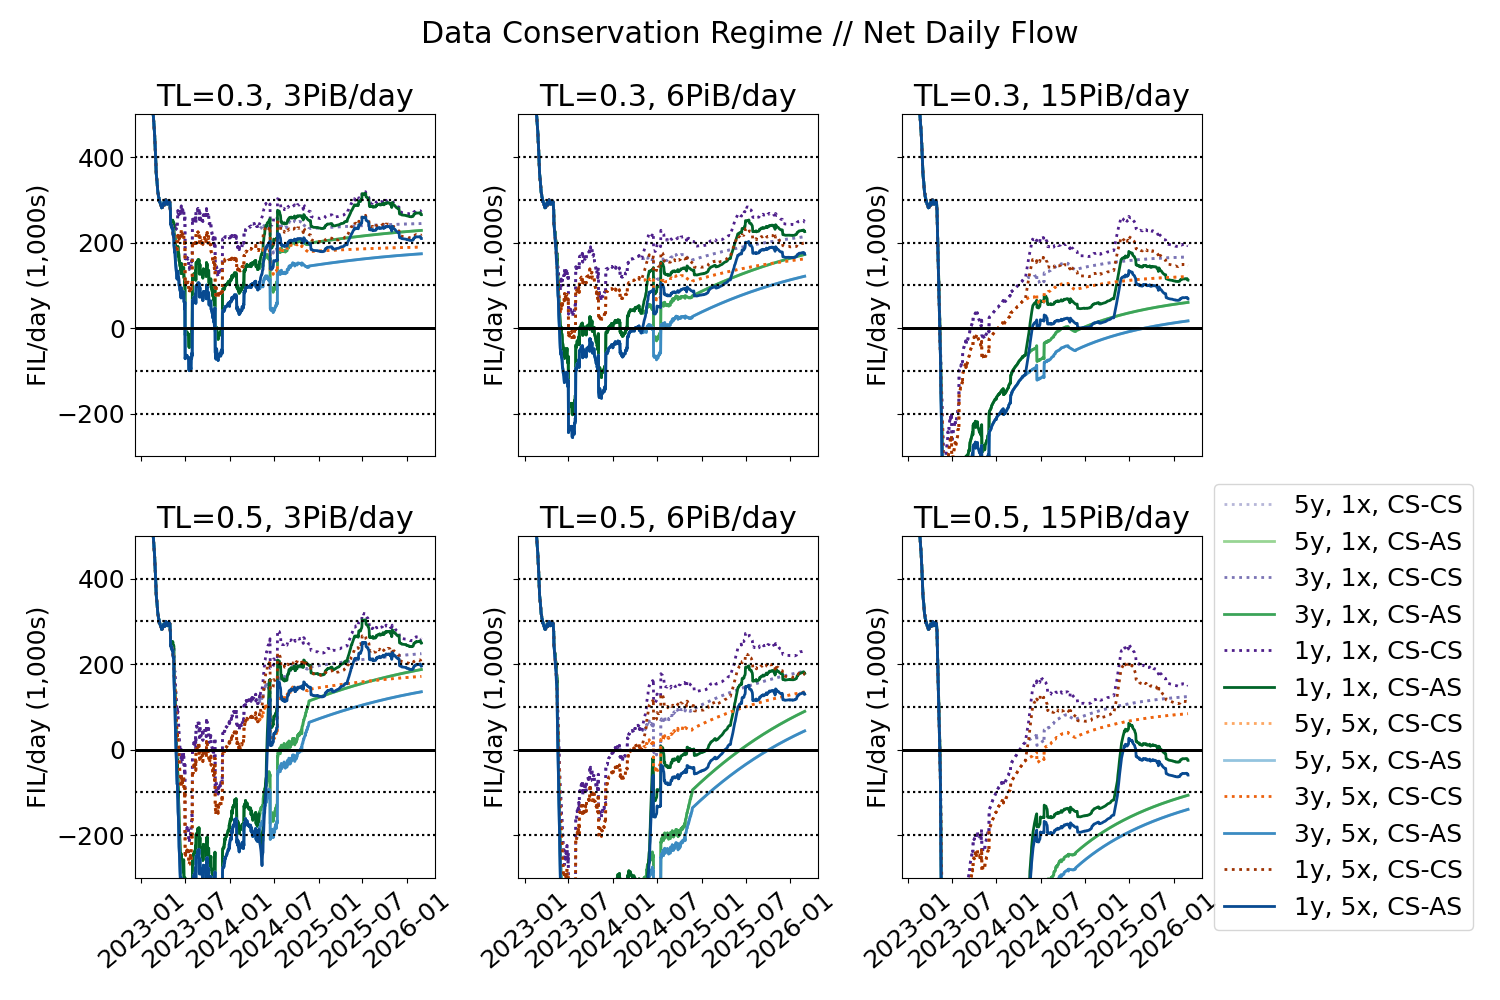

In [47]:
regime='data_conserved'

min_time = datetime.date(2023,1,1)
max_time = datetime.date(2026,3,1)

fig, axes = plt.subplots(nrows=len(target_locks), 
                         ncols=len(onboardings), 
                         figsize=(15,10), 
                         sharex=True, 
                         sharey=True)
for bi, burn_boost in enumerate(burn_boosts):
    for ti, target_lock_i in enumerate(target_locks):
        for oi, onboarding_i in enumerate(onboardings):
            ax = axes[ti,oi]
            for yi, yr in enumerate(years[::-1]):
                for fi, fpr_i in enumerate([0.8]):
                    cmap_idx = bi*len(burn_boosts)
                    cmap = cm.get_cmap(colormap_vecs[cmap_idx])
                    c = cmap(cmap_access_vec[yi])
                    
                    key = f'Scenario-2_CSCS_TargetRBP={onboarding_i}_FPR={fpr_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
                    plt_df = duration_loop_results[key]['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                    plt_df = filter_df_date(plt_df, min_time, max_time)
                    plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                    plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                    plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                    plt_df['netflow'] = plt_df['cum_netflow'].diff()
                    ax.plot(plt_df['date'], plt_df['netflow'].rolling(30).mean()/1000, linestyle=':', label=f'{yr}y, {burn_boost}x, CS-CS', color=c, lw=2)
                    
                    cmap_idx = bi*len(burn_boosts)+1
                    cmap = cm.get_cmap(colormap_vecs[cmap_idx])
                    c = cmap(cmap_access_vec[yi])
                    key = f'Scenario-2_CSAS_TargetRBP={onboarding_i}_FPR={fpr_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
                    plt_df = duration_loop_results[key]['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                    plt_df = filter_df_date(plt_df, min_time, max_time)
                    plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                    plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                    plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                    plt_df['netflow'] = plt_df['cum_netflow'].diff()
                    ax.plot(plt_df['date'], plt_df['netflow'].rolling(30).mean()/1000, label=f'{yr}y, {burn_boost}x, CS-AS', color=c, lw=2)
                    
            ax.axhline(-200, linestyle=':', color='k')
            ax.axhline(-100, linestyle=':', color='k')
            ax.axhline(0, linestyle='-', color='k', linewidth=2)
            ax.axhline(100, linestyle=':', color='k')
            ax.axhline(200, linestyle=':', color='k')
            ax.axhline(300, linestyle=':', color='k')
            ax.axhline(400, linestyle=':', color='k')
            ax.set_title(f'TL={target_lock_i}, {onboarding_i}PiB/day')
            ax.tick_params(axis='x', labelrotation=40)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            ax.set_ylabel("FIL/day (1,000s)")
            ax.set_ylim(-300,500)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.suptitle('Data Conservation Regime // Net Daily Flow')
plt.tight_layout();
plt.savefig(os.path.join(results_folder, f'1a_net_daily_flow_{regime}.png'))

### 1b. Net daily flow
* Across new average durations in {1,3,5}yr
* New target locks in {0.3,0.4,0.5}
* And future burning boosted by {1x,5x,10x}
* **Without** SDM applied
* FIL Conservation Regime

<IPython.core.display.Javascript object>


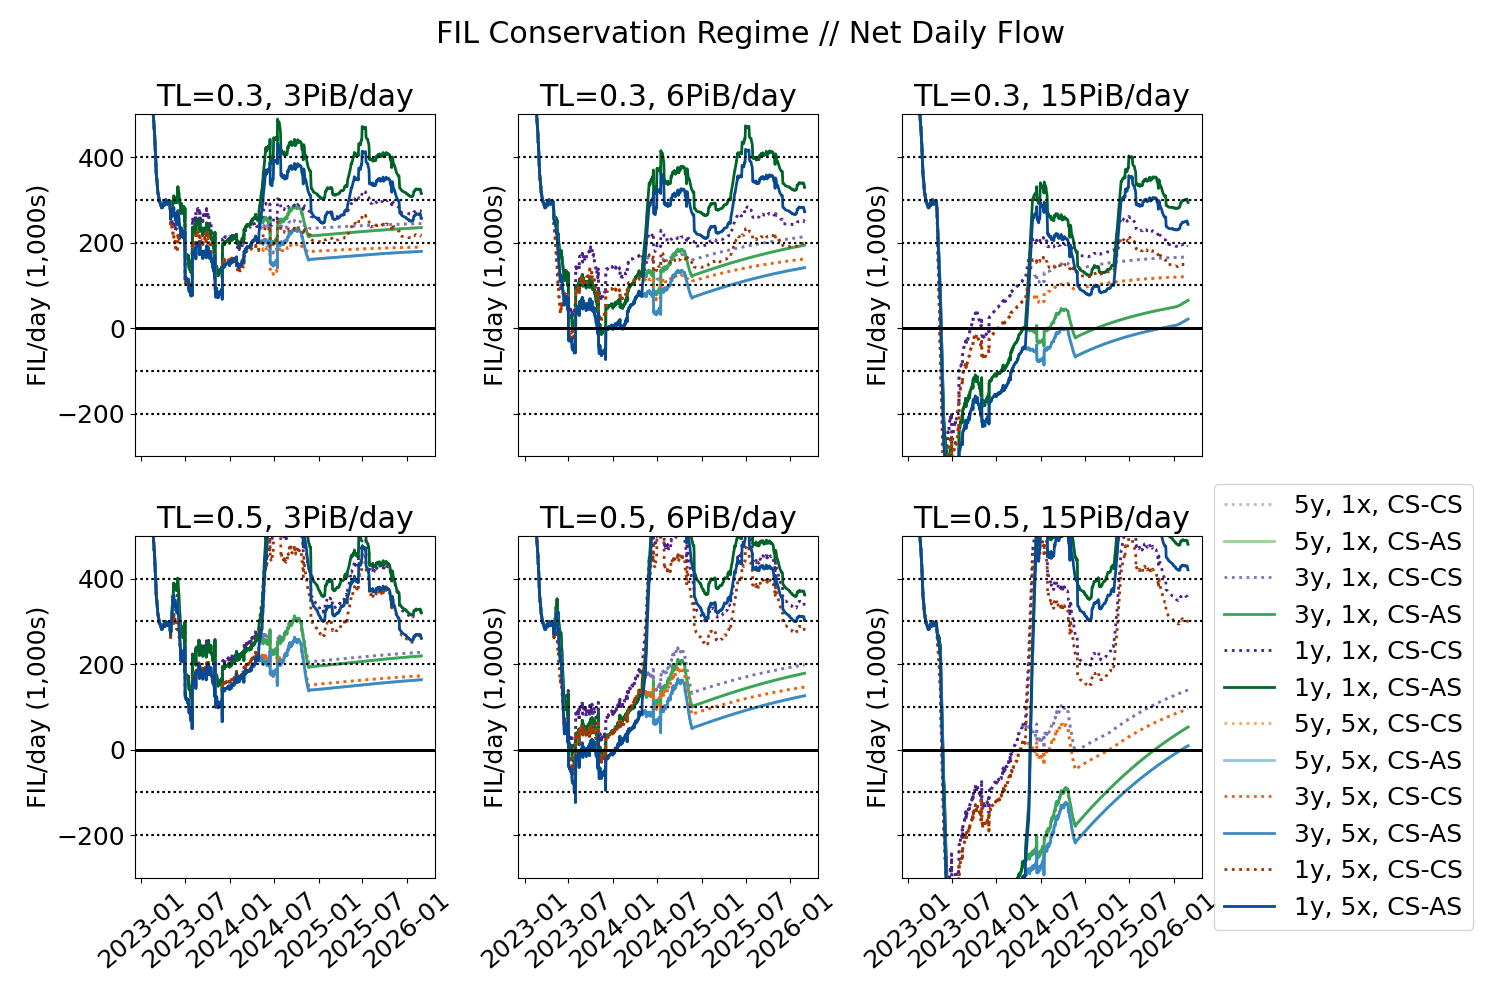

In [49]:
regime='fil_conserved'

min_time = datetime.date(2023,1,1)
max_time = datetime.date(2026,3,1)

fig, axes = plt.subplots(nrows=len(target_locks), 
                         ncols=len(onboardings), 
                         figsize=(15,10), 
                         sharex=True, 
                         sharey=True)
for bi, burn_boost in enumerate(burn_boosts):
    for ti, target_lock_i in enumerate(target_locks):
        for oi, onboarding_i in enumerate(onboardings):
            ax = axes[ti,oi]
            for yi, yr in enumerate(years[::-1]):
                for fi, fpr_i in enumerate([0.8]):
                    cmap_idx = bi*len(burn_boosts)
                    cmap = cm.get_cmap(colormap_vecs[cmap_idx])
                    c = cmap(cmap_access_vec[yi])
                    
                    key = f'Scenario-2_CSCS_TargetRBP={onboarding_i}_FPR={fpr_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
                    plt_df = duration_loop_results[key]['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                    plt_df = filter_df_date(plt_df, min_time, max_time)
                    plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                    plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                    plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                    plt_df['netflow'] = plt_df['cum_netflow'].diff()
                    ax.plot(plt_df['date'], plt_df['netflow'].rolling(30).mean()/1000, linestyle=':', label=f'{yr}y, {burn_boost}x, CS-CS', color=c, lw=2)
                    
                    cmap_idx = bi*len(burn_boosts)+1
                    cmap = cm.get_cmap(colormap_vecs[cmap_idx])
                    c = cmap(cmap_access_vec[yi])
                    key = f'Scenario-2_CSAS_TargetRBP={onboarding_i}_FPR={fpr_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
                    plt_df = duration_loop_results[key]['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                    plt_df = filter_df_date(plt_df, min_time, max_time)
                    plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                    plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                    plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                    plt_df['netflow'] = plt_df['cum_netflow'].diff()
                    ax.plot(plt_df['date'], plt_df['netflow'].rolling(30).mean()/1000, label=f'{yr}y, {burn_boost}x, CS-AS', color=c, lw=2)
                    
            ax.axhline(-200, linestyle=':', color='k')
            ax.axhline(-100, linestyle=':', color='k')
            ax.axhline(0, linestyle='-', color='k', linewidth=2)
            ax.axhline(100, linestyle=':', color='k')
            ax.axhline(200, linestyle=':', color='k')
            ax.axhline(300, linestyle=':', color='k')
            ax.axhline(400, linestyle=':', color='k')
            ax.set_title(f'TL={target_lock_i}, {onboarding_i}PiB/day')
            ax.tick_params(axis='x', labelrotation=40)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            ax.set_ylabel("FIL/day (1,000s)")
            ax.set_ylim(-300,500)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.suptitle('FIL Conservation Regime // Net Daily Flow')
plt.tight_layout();
plt.savefig(os.path.join(results_folder, f'1a_net_daily_flow_{regime}.png'))

For additional context, the circulating supply is also given in the following two images across the same range of scenarios.

### 1a. Projected circulating supply
* Across new average durations in {1,3,5}yr
* New target locks in {0.3,0.4,0.5}
* And future burning boosted by {1x,5x,10x}
* **Without** SDM applied
* Data Conservation Regime

<IPython.core.display.Javascript object>


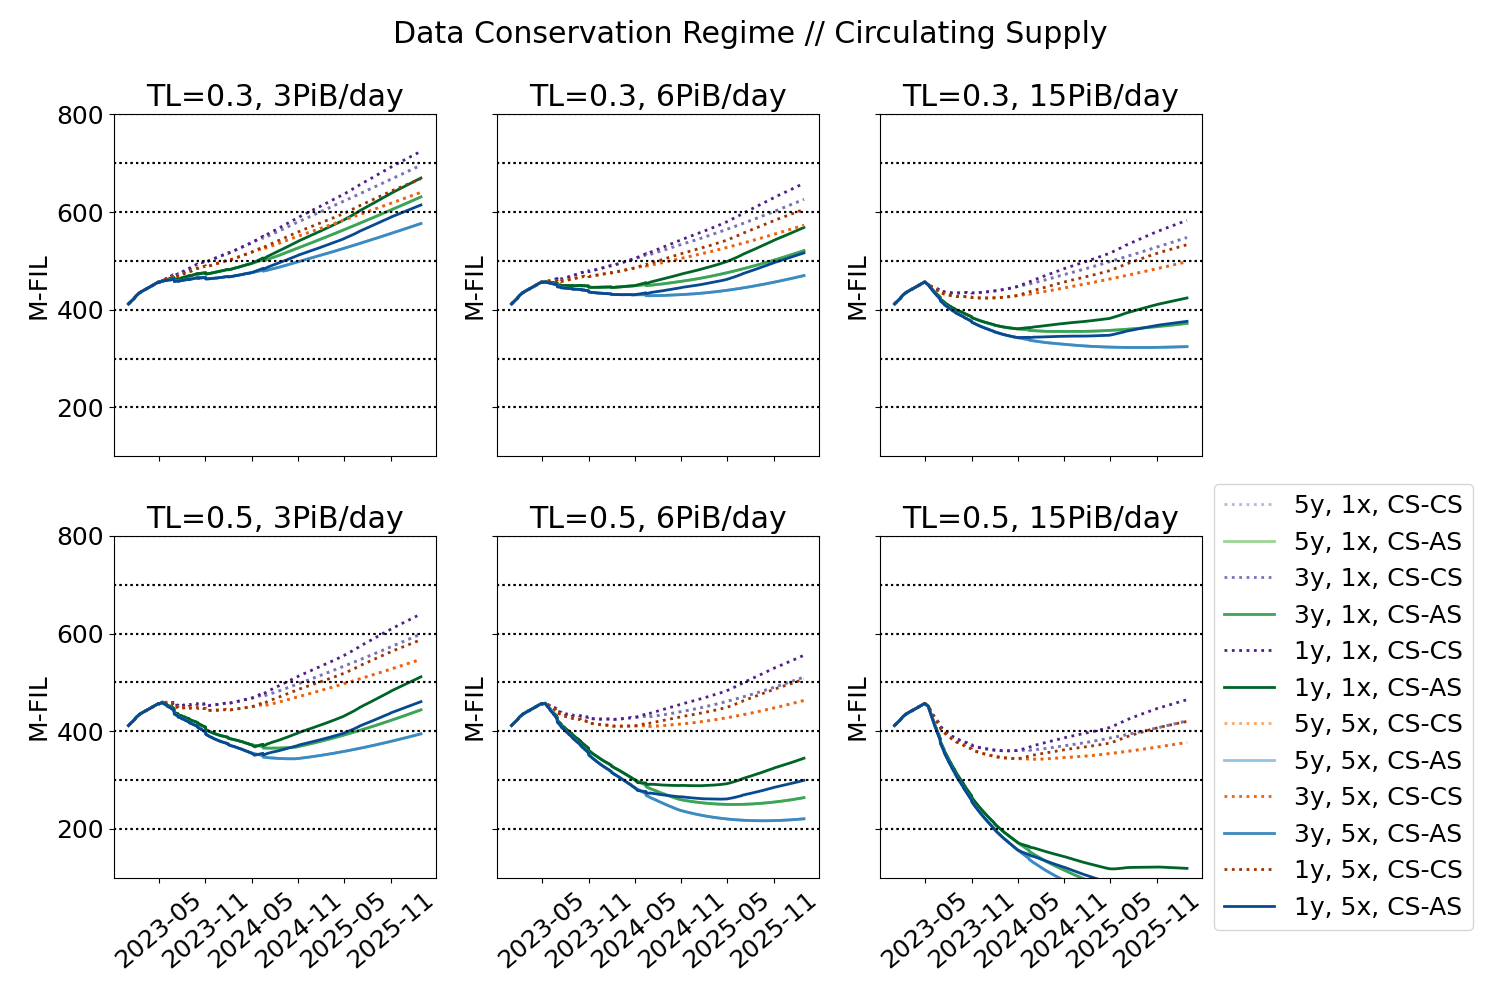

In [53]:
regime='data_conserved'

min_time = datetime.date(2023,1,1)
max_time = datetime.date(2026,3,1)

fig, axes = plt.subplots(nrows=len(target_locks), 
                         ncols=len(onboardings), 
                         figsize=(15,10), 
                         sharex=True, 
                         sharey=True)
for bi, burn_boost in enumerate(burn_boosts):
    for ti, target_lock_i in enumerate(target_locks):
        for oi, onboarding_i in enumerate(onboardings):
            ax = axes[ti,oi]
            for yi, yr in enumerate(years[::-1]):
                for fi, fpr_i in enumerate([0.8]):
                    cmap_idx = bi*len(burn_boosts)
                    cmap = cm.get_cmap(colormap_vecs[cmap_idx])
                    c = cmap(cmap_access_vec[yi])
                    
                    key = f'Scenario-2_CSCS_TargetRBP={onboarding_i}_FPR={fpr_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
                    plt_df = duration_loop_results[key]['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                    plt_df = filter_df_date(plt_df, min_time, max_time)
                    plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                    plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                    plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                    plt_df['netflow'] = plt_df['cum_netflow'].diff()
                    ax.plot(plt_df['date'], plt_df['cum_netflow']/MEGA, linestyle=':', label=f'{yr}y, {burn_boost}x, CS-CS', color=c, lw=2)
                    
                    cmap_idx = bi*len(burn_boosts)+1
                    cmap = cm.get_cmap(colormap_vecs[cmap_idx])
                    c = cmap(cmap_access_vec[yi])
                    key = f'Scenario-2_CSAS_TargetRBP={onboarding_i}_FPR={fpr_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
                    plt_df = duration_loop_results[key]['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                    plt_df = filter_df_date(plt_df, min_time, max_time)
                    plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                    plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                    plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                    plt_df['netflow'] = plt_df['cum_netflow'].diff()
                    ax.plot(plt_df['date'], plt_df['cum_netflow']/MEGA, label=f'{yr}y, {burn_boost}x, CS-AS', color=c, lw=2)
                    
            ax.axhline(800, linestyle=':', color='k')
            ax.axhline(700, linestyle=':', color='k')
            ax.axhline(600, linestyle=':', color='k')
            ax.axhline(500, linestyle=':', color='k')
            ax.axhline(400, linestyle=':', color='k')
            ax.axhline(300, linestyle=':', color='k')
            ax.axhline(200, linestyle=':', color='k')
            ax.set_title(f'TL={target_lock_i}, {onboarding_i}PiB/day')
            ax.tick_params(axis='x', labelrotation=40)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            ax.set_ylabel("M-FIL")
            ax.set_ylim(100,800)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.suptitle('Data Conservation Regime // Circulating Supply')
plt.tight_layout();
plt.savefig(os.path.join(results_folder, f'1a_cs_{regime}.png'))

### 1b. Projected circulating supply
* Across new average durations in {1,3,5}yr
* New target locks in {0.3,0.4,0.5}
* And future burning boosted by {1x,5x,10x}
* **Without** SDM applied
* FIL Conservation Regime

<IPython.core.display.Javascript object>


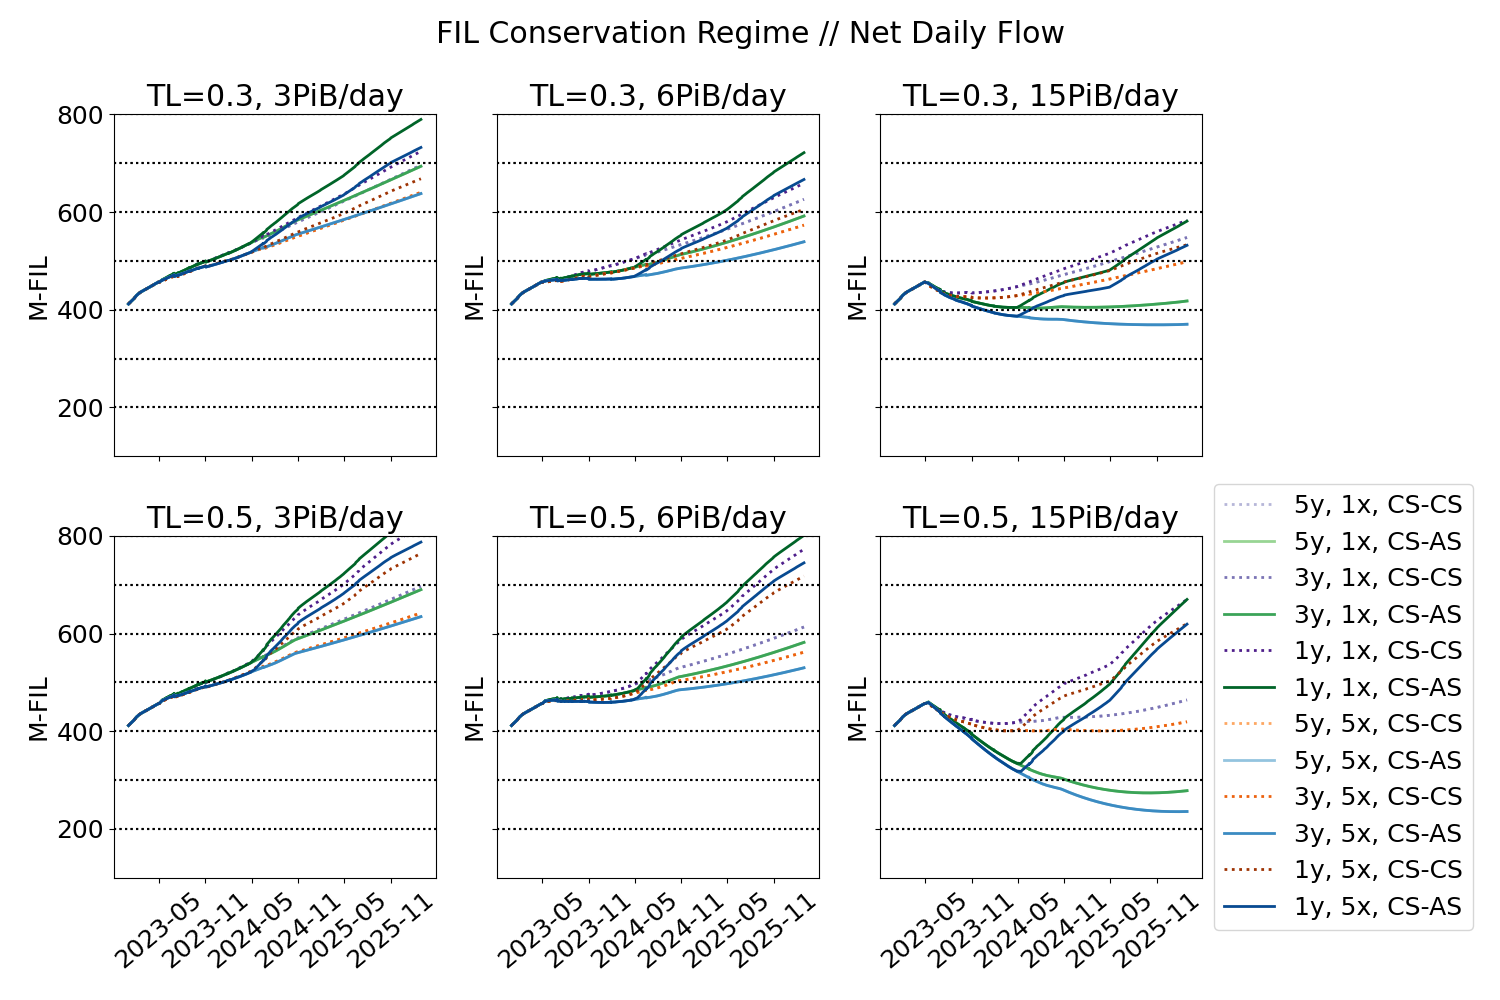

In [55]:
regime='fil_conserved'

min_time = datetime.date(2023,1,1)
max_time = datetime.date(2026,3,1)

fig, axes = plt.subplots(nrows=len(target_locks), 
                         ncols=len(onboardings), 
                         figsize=(15,10), 
                         sharex=True, 
                         sharey=True)
for bi, burn_boost in enumerate(burn_boosts):
    for ti, target_lock_i in enumerate(target_locks):
        for oi, onboarding_i in enumerate(onboardings):
            ax = axes[ti,oi]
            for yi, yr in enumerate(years[::-1]):
                for fi, fpr_i in enumerate([0.8]):
                    cmap_idx = bi*len(burn_boosts)
                    cmap = cm.get_cmap(colormap_vecs[cmap_idx])
                    c = cmap(cmap_access_vec[yi])
                    
                    key = f'Scenario-2_CSCS_TargetRBP={onboarding_i}_FPR={fpr_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
                    plt_df = duration_loop_results[key]['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                    plt_df = filter_df_date(plt_df, min_time, max_time)
                    plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                    plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                    plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                    plt_df['netflow'] = plt_df['cum_netflow'].diff()
                    ax.plot(plt_df['date'], plt_df['cum_netflow']/MEGA, linestyle=':', label=f'{yr}y, {burn_boost}x, CS-CS', color=c, lw=2)
                    
                    cmap_idx = bi*len(burn_boosts)+1
                    cmap = cm.get_cmap(colormap_vecs[cmap_idx])
                    c = cmap(cmap_access_vec[yi])
                    key = f'Scenario-2_CSAS_TargetRBP={onboarding_i}_FPR={fpr_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
                    plt_df = duration_loop_results[key]['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                    plt_df = filter_df_date(plt_df, min_time, max_time)
                    plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                    plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                    plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                    plt_df['netflow'] = plt_df['cum_netflow'].diff()
                    ax.plot(plt_df['date'], plt_df['cum_netflow']/MEGA, label=f'{yr}y, {burn_boost}x, CS-AS', color=c, lw=2)
                    
            ax.axhline(800, linestyle=':', color='k')
            ax.axhline(700, linestyle=':', color='k')
            ax.axhline(600, linestyle=':', color='k')
            ax.axhline(500, linestyle=':', color='k')
            ax.axhline(400, linestyle=':', color='k')
            ax.axhline(300, linestyle=':', color='k')
            ax.axhline(200, linestyle=':', color='k')
            ax.set_title(f'TL={target_lock_i}, {onboarding_i}PiB/day')
            ax.tick_params(axis='x', labelrotation=40)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            ax.set_ylabel("M-FIL")
            ax.set_ylim(100,800)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.suptitle('FIL Conservation Regime // Net Daily Flow')
plt.tight_layout();
plt.savefig(os.path.join(results_folder, f'1a_cs_{regime}.png'))

## Factors explaining changes to circulating supply

An issue with the above images is separating out how much the change in ciriculating supply comes from individual factors --- burn, sector duration, target lock & onboard --- and over what timescale. 

Concretely, if SDM implemented, and there's a 1.66x increase in TL, a 4x increase in onboarding, and 5x increase in average duration, this is will give a strong change in circulating supply. Across different ranges of times --- 0-1yrs, 0-2yrs, 0-3yrs etc --- what is the change attributable to each factor?

In [ ]:
# offline_folder = 'offline_info'
# fp = os.path.join(offline_folder, 'duration_loop_results_Feb14_2023.pkl')
# if os.path.exists(fp):
#     with open(fp, 'rb') as f:
#         duration_loop_results = pickle.load(f)
        
regimes=['data_conserved', 'fil_conserved']
MEGA=10 ** 6
def filter_df_date(df_in, min_date, max_date):
    df_out = df_in[(df_in['date']>= pd.to_datetime(min_date)) & (df_in['date']<=pd.to_datetime(max_date))]
    return df_out
analysis_df = pd.DataFrame()
analysis_df_i = pd.DataFrame()
for regime in regimes:
    for bi, burn_boost_i in enumerate(burn_boosts):
        for ti, target_lock_i in enumerate(target_locks):
            for oi, onboarding_i in enumerate(onboardings):
                for yi, yr in enumerate(years):
                    key=f'Scenario-2_CSAS_TargetRBP={onboarding_i}_FPR=0.8({yr}-Y_{target_lock_i}-LT_{burn_boost_i}-bb-{regime}-regime)'
                    analysis_df_i = duration_loop_results[key]['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']].copy()
                    analysis_df_i['scenario'] = f'Scenario-3_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost_i}-bb)'
                    analysis_df_i['onboard'] = onboarding_i
                    analysis_df_i['duration'] = yr
                    analysis_df_i['target_lock'] = target_lock_i
                    analysis_df_i['burn_boost'] = burn_boost_i
                    analysis_df_i['circ_supply'] = analysis_df_i['circ_supply'] / MEGA
                    key2=f'Scenario-2_CSCS_TargetRBP=6_FPR=0.8(1-Y_0.3-LT_1-bb-{regime}-regime)'
                    analysis_df_i['circ_supply_delta'] = analysis_df_i['circ_supply'] - duration_loop_results[key2]['rbp_roi']['circ_supply'] / MEGA
                    analysis_df_i['netflow'] = analysis_df_i['circ_supply'].diff()
                    analysis_df_i['regime'] = regime
                    analysis_df = pd.concat([analysis_df, analysis_df_i])
analysis_df.dropna(inplace=True)
analysis_df.reset_index(inplace=True)

In [ ]:
analysis_df

In [ ]:
def get_beta_df(regime, y_val_str='cs_delta'):
    beta_df = pd.DataFrame({'year': [],
                               'beta_burn_boost': [],
                               'beta_duration':[], 
                               'beta_target_lock':[], 
                               'beta_onboard': []})
    yrs_ahead = [1,2,3,4,5,6,7]
    for yr_ahead in yrs_ahead:
        analysis_df.date = pd.to_datetime(analysis_df['date'])
        min_time = datetime.date(2023,3,1)
        max_time = datetime.date(2023+yr_ahead,3,1)
        filtered_df = filter_df_date(analysis_df, min_time, max_time)
        filtered_df = filtered_df[filtered_df['regime']==regime]
#         factor = lambda x: (x / x.min())
        factor = lambda x: (x / x.min() - 1)
        filtered_df['onboard_factor'] = filtered_df['onboard'].pipe(factor)
        filtered_df['target_lock_factor'] = filtered_df['target_lock'].pipe(factor)
        filtered_df['burn_boost_factor'] = filtered_df['burn_boost'].pipe(factor)
        filtered_df['duration_factor'] = filtered_df['duration'].pipe(factor)
        if y_val_str=='cs_delta':
            y_vals = filtered_df.circ_supply_delta.values
        elif y_val_str=='netflow_daily':
            y_vals = filtered_df.netflow.values
        else:
            print('error')
        
        def model(y=None, 
                  onboard=filtered_df.onboard_factor.values, 
                  burn_boost=filtered_df.burn_boost_factor.values,
                  target_lock=filtered_df.target_lock_factor.values,
                  duration=filtered_df.duration_factor.values,
                 ):
            y_sigma = numpyro.sample('y_sigma', dist.HalfNormal(scale=10))
            beta0 = numpyro.sample('beta0', dist.Normal(0,10))
            beta_onboard = numpyro.sample('beta_onboard', dist.Normal(0,10))
            beta_duration = numpyro.sample('beta_duration', dist.Normal(0,10))
            beta_target_lock = numpyro.sample('beta_target_lock', dist.Normal(0,10))
            beta_burn_boost = numpyro.sample('beta_burn_boost', dist.Normal(0,10)) 
            mu = beta0 + beta_onboard*onboard + beta_duration*duration + beta_target_lock*target_lock + beta_burn_boost*burn_boost
            numpyro.sample('obs', dist.Normal(loc=mu, scale=y_sigma), obs=y)
        mcmc = MCMC(
                    NUTS(model), 
                    num_warmup=1000, num_samples=500)
        mcmc.run(random.PRNGKey(0), y=jnp.array(y_vals), 
                  onboard=jnp.array(filtered_df.onboard_factor.values), 
                  burn_boost=jnp.array(filtered_df.burn_boost_factor.values),
                  target_lock=jnp.array(filtered_df.target_lock_factor.values),
                  duration=jnp.array(filtered_df.duration_factor.values),
                )
        mcmc.print_summary()
        samples_ = mcmc.get_samples()
        beta_df = beta_df.append({'year': f'0-{yr_ahead}', 
                           'beta_burn_boost': samples_['beta_burn_boost'].mean(),
                           'beta_duration': samples_['beta_duration'].mean(),
                           'beta_target_lock': samples_['beta_target_lock'].mean(),
                           'beta_onboard': samples_['beta_onboard'].mean(),
                          }, ignore_index=True)
    return beta_df

In [ ]:
beta_netflow_daily_df_dataconserved = get_beta_df('data_conserved', y_val_str='netflow_daily')
beta_cs_delta_df_dataconserved = get_beta_df('data_conserved', y_val_str='cs_delta')
beta_netflow_daily_df_filconserved = get_beta_df('fil_conserved', y_val_str='netflow_daily')
beta_cs_delta_df_filconserved = get_beta_df('fil_conserved', y_val_str='cs_delta')

In [ ]:
with open(os.path.join(offline_folder, 'beta_df_Feb15_2023.pkl'), 'wb') as f:
    out_dict = {}
    out_dict['beta_netflow_daily_df_dataconserved'] = beta_netflow_daily_df_dataconserved
    out_dict['beta_cs_delta_df_dataconserved'] = beta_cs_delta_df_dataconserved
    out_dict['beta_netflow_daily_df_filconserved'] = beta_netflow_daily_df_filconserved
    out_dict['beta_cs_delta_df_filconserved'] = beta_cs_delta_df_filconserved
    pickle.dump(out_dict, f)

### Impact for burn_factor=10, duration_factor=5, target_lock_factor=1.66, onboard_factor=4

In [ ]:
def get_impact_for(beta_daily_df,beta_agg_df,
                   yrs_ahead='0-1',burn_factor=9, duration_factor=4, 
                   target_lock_factor=0.66, onboard_factor=3):
    '''
    Note
    The arguments here are like percentage increases.
    Example1: burn_factor=9 means 900% increase, so 1x-->10x
    Example2: target_lock_factor=0.66 means a 66% increase, so 1x-->1.66x, or 0.3 to 0.5
    '''
    betas_daily = beta_daily_df[beta_daily_df['year'] == yrs_ahead][['beta_burn_boost', 'beta_duration', 'beta_target_lock', 'beta_onboard']].values.flatten().astype(float)
    betas_agg = beta_agg_df[beta_agg_df['year'] == yrs_ahead][['beta_burn_boost', 'beta_duration', 'beta_target_lock', 'beta_onboard']].values.flatten().astype(float)
    impacts_daily = betas_daily * np.array([burn_factor,duration_factor,target_lock_factor,onboard_factor]).flatten().astype(float)
    impacts_agg = betas_agg * np.array([burn_factor,duration_factor,target_lock_factor,onboard_factor]).flatten().astype(float)
    yrs_ahead_int = int(yrs_ahead[2])
    df= pd.DataFrame({'Range (yrs)':[yrs_ahead, yrs_ahead, yrs_ahead, yrs_ahead],
                      'Years ahead': [yrs_ahead_int, yrs_ahead_int, yrs_ahead_int, yrs_ahead_int],
                      'Contribution': ['burning', 'duration', 'target_lock', 'onboard'],
                  'Betas_daily': betas_daily.round(2),
                    'Betas_agg': betas_agg.round(2),
                  'Factor':np.array([burn_factor,duration_factor,target_lock_factor,onboard_factor]).round(2),
                 'Av. Daily impact k-FIL': (1000*impacts_daily).round(0).astype(int),
                 'Agg. impact M-FIL': impacts_agg.round(-1).astype(int)
                 })
    return df



In [ ]:
with open(os.path.join(offline_folder, 'beta_df_Feb15_2023.pkl'), 'rb') as f:
    out_dict = pickle.load(f)
beta_netflow_daily_df_dataconserved = out_dict['beta_netflow_daily_df_dataconserved']
beta_cs_delta_df_dataconserved = out_dict['beta_cs_delta_df_dataconserved']
beta_netflow_daily_df_filconserved = out_dict['beta_netflow_daily_df_filconserved']
beta_cs_delta_df_filconserved = out_dict['beta_cs_delta_df_filconserved']

In [ ]:
regime = 'fil_conserved'  # can be data_conserved or fil_conserved
if regime == 'data_conserved':
    beta_netflow_daily_df = beta_netflow_daily_df_dataconserved
    beta_cs_delta_df = beta_cs_delta_df_dataconserved
elif regime == 'fil_conserved':
    beta_netflow_daily_df = beta_netflow_daily_df_filconserved
    beta_cs_delta_df = beta_cs_delta_df_filconserved

yrs_list = ['0-1','0-2','0-3','0-4','0-5','0-6','0-7']    
all_yrs_df = pd.DataFrame()
for yrs in yrs_list:
    yr_df=get_impact_for(beta_netflow_daily_df,beta_cs_delta_df,
                         yrs_ahead=yrs,
                         burn_factor=2, duration_factor=4, target_lock_factor=0.66, onboard_factor=3)
    display(yr_df)
    all_yrs_df = all_yrs_df.append(yr_df)

In [ ]:
plt.figure()
sns.lineplot(
    data=all_yrs_df.reset_index(),
    x="Years ahead", y="Av. Daily impact k-FIL", hue="Contribution",
    markers=True, dashes=False
); 
plt.title('%s \n Scenario={SDM, 3xburn, 1.66xTL, 4xOnboard, 5xDuration}' % (regime,));
output_fp = '%s-sdm-3xburn-1_66xTL-4xOnboard-5xDuration.png' % (regime,)
plt.savefig(os.path.join(results_folder, output_fp))

In [ ]:
plt.figure()
# sns.lineplot(
#     data=all_yrs_df.reset_index(),
#     x="Years ahead", y="Agg. impact M-FIL", hue="Contribution",
#     markers=True, dashes=True
# );
plt_df = all_yrs_df.reset_index()
subset_df = plt_df[plt_df['Contribution']=='burning']
plt.plot(subset_df['Years ahead'], subset_df['Agg. impact M-FIL'], label='burning')
subset_df = plt_df[plt_df['Contribution']=='duration']
plt.plot(subset_df['Years ahead'], subset_df['Agg. impact M-FIL'], label='duration')
subset_df = plt_df[plt_df['Contribution']=='target_lock']
plt.plot(subset_df['Years ahead'], subset_df['Agg. impact M-FIL'], label='target_lock')
subset_df = plt_df[plt_df['Contribution']=='onboard']
plt.plot(subset_df['Years ahead'], subset_df['Agg. impact M-FIL'], label='onboard', linestyle='--')
plt.legend()
plt.ylabel('Agg. impact M-FIL')

plt.title('%s \n Scenario={SDM, 3xburn, 1.66xTL, 4xOnboard, 5xDuration}' % (regime,));
output_fp = '%s-sdm-3xburn-1_66xTL-4xOnboard-5xDuration-aggregate.png' % (regime,)
plt.savefig(os.path.join(results_folder, output_fp))